# Beam Shaping with Extended Source

This example demonstrates how to use the `ExtendedSourceOptic` feature to model a collimated
Gaussian beam (from a single-mode fiber) illuminating a beam shaping singlet.
The singlet transforms the Gaussian input into a flat-top irradiance profile.

Key concepts:
- Setting up an `SMFSource` (Single-Mode Fiber Source)
- Wrapping an optical system with `ExtendedSourceOptic`
- Visualizing the system with source rays
- Computing the irradiance at the detector

In [1]:
import optiland.backend as be
from optiland.optic import Optic, ExtendedSourceOptic
from optiland.sources import SMFSource
from optiland.analysis import IncoherentIrradiance
from optiland.physical_apertures import RectangularAperture

## Define the Optical System

We create a beam shaping singlet with a Forbes QBFS aspheric surface.

In [2]:
gaussian_beam_waist = 5.0  # in mm
wavelength_um = 0.55  # in µm

# Forbes QBFS surface parameters
forbes_terms = {
    0: 0.5414,
    1: 0.6689,
    2: 0.3409,
    3: -0.0537,
    4: -0.3960,
    5: -0.2991,
    6: 0.3921,
}
forbes_norm_radius = 30.3636
top_hat_radius = 25.0

lens = Optic()
lens.set_aperture(aperture_type='EPD', value=gaussian_beam_waist * 6)
lens.add_wavelength(value=wavelength_um, is_primary=True)
lens.set_field_type(field_type='angle')
lens.add_field(y=0.0)

lens.add_surface(index=0, thickness=be.inf)
lens.add_surface(
    index=1, thickness=20.0, is_stop=True,
    aperture=RectangularAperture(x_min=-15, x_max=15, y_min=-15, y_max=15),
)
lens.add_surface(
    index=2, surface_type='forbes_qbfs', radius=5.7410, conic=-2.3165,
    thickness=15.0, material='N-BK7',
    radial_terms=forbes_terms, norm_radius=forbes_norm_radius, aperture=30.0,
)
lens.add_surface(index=3, surface_type='standard', radius=be.inf, thickness=70.0, material='air')
lens.add_surface(
    index=4,
    aperture=RectangularAperture(
        x_min=-top_hat_radius * 1.1, x_max=top_hat_radius * 1.1,
        y_min=-top_hat_radius * 1.1, y_max=top_hat_radius * 1.1,
    ),
)

## Create the Extended Source

We use `SMFSource` with near-zero divergence to approximate a collimated Gaussian beam.
Then we wrap the optic with `ExtendedSourceOptic`.

In [3]:
mfd_microns = gaussian_beam_waist * 2 * 1000  # MFD in µm

source = SMFSource(
    mfd_um=mfd_microns,
    wavelength_um=wavelength_um,
    divergence_deg_1e2=1e-10,  # Virtually zero divergence for collimation
    total_power=1.0,
    position=(0, 0, 0),
)

ext_optic = ExtendedSourceOptic(lens, source)
print(source)

SMFSource(mfd=10000.0µm, divergence=1e-10°, wavelength=0.55µm, power=1.0W, mode=extended, position=(0.0, 0.0, 0.0))


## Draw the System

Visualize the optical system with the traced source rays.

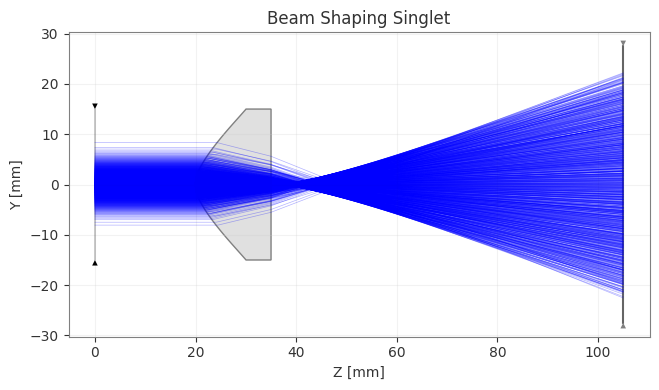

In [4]:
fig, ax = ext_optic.draw(num_rays=1000, title='Beam Shaping Singlet')

## Irradiance at the Detector

Compute and plot the irradiance distribution at the image plane.

(<Figure size 700x500 with 2 Axes>,
 array([[<Axes: title={'center': '(User Rays: 0.0)'}, xlabel='X (mm)', ylabel='Y (mm)'>]],
       dtype=object))

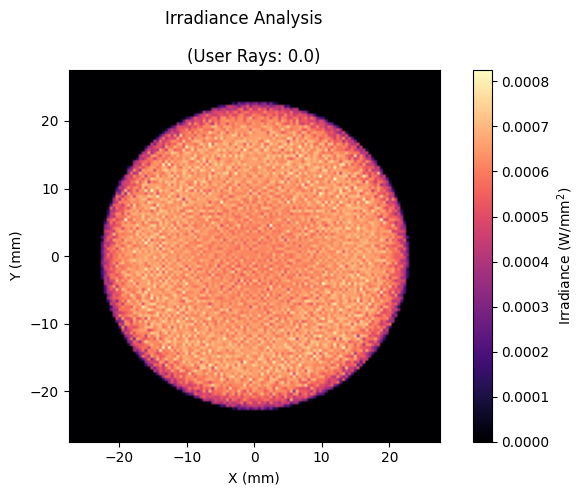

In [5]:
analysis = IncoherentIrradiance(
    lens, source=source, num_rays=100_000,
    detector_surface=-1, res=(128, 128),
)
analysis.view(figsize=(7, 5), cmap='magma', normalize=False)